<a href="https://colab.research.google.com/github/christinawanggg/ait-dl-deepfake/blob/main/AIT_DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# AIT - Deep Learning Fall 2021
# Final Project
# Scaffolding and assignment completed by Christina Wang and Isabel Grondin

In [1]:
# Loading Libraries
import numpy as np 
import pandas as pd 
import zipfile
from math import sqrt
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import os
import tensorflow as tf
from keras.preprocessing import image
from keras.utils import np_utils
from skimage.transform import resize
from PIL import Image

from tensorflow import keras
model = tf.keras.models.Sequential()


# Data Set

*   Celeb Deepfake 1: https://drive.google.com/file/d10NGF38RgF8FZneKOuCOdRIsPzpC7_WDd/view


The Celeb Deepfake 1 dataset includes a combination of 1203 real and fake/synthesized videos of celebrities from Youtube. The current state of our project is utilizing this data set.

## Data Extraction

First, we needed to extract all of the videos in the data from a zip file.



In [2]:
# Imports needed for data extraction
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile


In [3]:
# using Pydrive to connect to Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

In [4]:
file_id = "10NGF38RgF8FZneKOuCOdRIsPzpC7_WDd"
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % file_id}).GetList()

In [5]:
downloaded = drive.CreateFile({'id': "10NGF38RgF8FZneKOuCOdRIsPzpC7_WDd"})
downloaded.GetContentFile('Celeb-DF.zip')

In [6]:
# extracting all the videos from the zip file

zip = zipfile.ZipFile("Celeb-DF.zip")
zip.extractall()
videoNameList = zip.namelist()

# Data Pre-Processing

We parsed the videos into individual jpg frames. We then resized and cropped the images so that they all shared the same dimensions. Finally, we extracted the images into a pixel array format and flattened the shape of all the images. 

In [7]:
# Imports needed for standardizing data set
import cv2
import math
from PIL import Image

In [8]:
# Cleaning up the data set

videoNameList.remove("Celeb-real/")
videoNameList.remove("Celeb-synthesis/")
videoNameList.remove("YouTube-real/")
videoNameList.remove("List_of_testing_videos.txt")

In [9]:
# balancing data set

drop_list = []
for i in range(len(videoNameList)):
  if 'Celeb-synthesis' in videoNameList[i]:
    drop_list.append(videoNameList[i])

for j in range(len(drop_list)):
  if j % 2 != 0:
    curr = drop_list[j]
    videoNameList.remove(curr)


In [10]:
print(len(videoNameList))

806


In [11]:
# Extracting an individual frame or jpg image from each video

videos_dict = {} # used to see both the video name and resulting filename
videos_frames = []
videos_listY = [] # serving as our 'Y'
count = 0


for i in range(len(videoNameList)):
  videoFile = "/content/" + videoNameList[i]
  cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
  frameRate = cap.get(5) # frame rate
  x=1
  results = []
  videos_dict[videoNameList[i]] = []
  frame_count = 1
  for j in range(1,8,1):
    frameId = cap.get(j) # current frame number
    ret, frame = cap.read()
    # if (frameId % math.floor(frameRate) == 0):
    filename ="frame%d-%d.jpg" % (count,frame_count)
    cv2.imwrite(filename, frame)
    videos_dict[videoNameList[i]].append(filename)
    videos_frames.append(filename) 
    frame_count += 1
    if 'real' in videoNameList[i]:
      results.append(1)
    elif 'synthesis' in videoNameList[i]:
      results.append(0)
  videos_listY.append(results)
  count+=1
  
cap.release()

In [12]:
print(videos_dict)

{'Celeb-real/id0_0000.mp4': ['frame0-1.jpg', 'frame0-2.jpg', 'frame0-3.jpg', 'frame0-4.jpg', 'frame0-5.jpg', 'frame0-6.jpg', 'frame0-7.jpg'], 'Celeb-real/id0_0001.mp4': ['frame1-1.jpg', 'frame1-2.jpg', 'frame1-3.jpg', 'frame1-4.jpg', 'frame1-5.jpg', 'frame1-6.jpg', 'frame1-7.jpg'], 'Celeb-real/id0_0002.mp4': ['frame2-1.jpg', 'frame2-2.jpg', 'frame2-3.jpg', 'frame2-4.jpg', 'frame2-5.jpg', 'frame2-6.jpg', 'frame2-7.jpg'], 'Celeb-real/id0_0003.mp4': ['frame3-1.jpg', 'frame3-2.jpg', 'frame3-3.jpg', 'frame3-4.jpg', 'frame3-5.jpg', 'frame3-6.jpg', 'frame3-7.jpg'], 'Celeb-real/id0_0004.mp4': ['frame4-1.jpg', 'frame4-2.jpg', 'frame4-3.jpg', 'frame4-4.jpg', 'frame4-5.jpg', 'frame4-6.jpg', 'frame4-7.jpg'], 'Celeb-real/id0_0005.mp4': ['frame5-1.jpg', 'frame5-2.jpg', 'frame5-3.jpg', 'frame5-4.jpg', 'frame5-5.jpg', 'frame5-6.jpg', 'frame5-7.jpg'], 'Celeb-real/id0_0006.mp4': ['frame6-1.jpg', 'frame6-2.jpg', 'frame6-3.jpg', 'frame6-4.jpg', 'frame6-5.jpg', 'frame6-6.jpg', 'frame6-7.jpg'], 'Celeb-real/

In [13]:
print(len(videos_dict))
print(len(videos_listY))

806
806


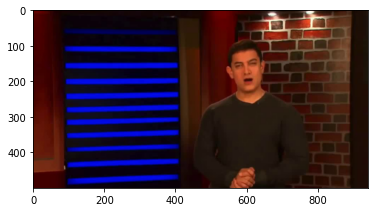

In [14]:
# Displaying a real image

img = plt.imread('frame0-1.jpg')
plt.imshow(img)


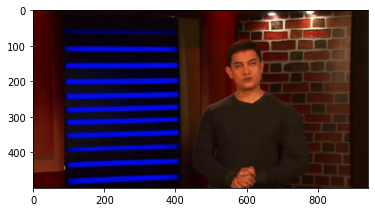

In [15]:
# Printing another frame for that same file

img = plt.imread('frame0-6.jpg')
plt.imshow(img)

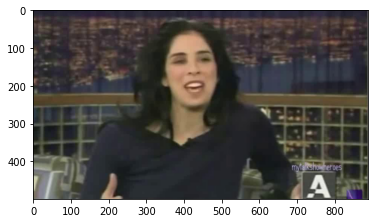

In [16]:
# Displaying a fake image

img2 = plt.imread('frame628-1.jpg')
plt.imshow(img2)


In [17]:
# Standardizing the mode of the images 

def changeColor(colorType):
  sizes = {}
  for i in range(len(videos_frames)):
    curr_image = Image.open(videos_frames[i])
  
    if curr_image.mode != colorType:
      png = curr_image.convert(colorType)
      background = Image.new(colorType, png.size, (255))
      png.save(videos_frames[i])

      sizes[videos_frames[i]] = curr_image.size

changeColor('RGB')

In [ ]:
# Storing the dimensions of all of the data in img_shapes for later usage

# img_shapes = []

# for key,value in videos_dict.items():
#   newim = Image.open(videos_dict[key])
#   data = np.array(newim)
#   img_shapes.append(data.shape)


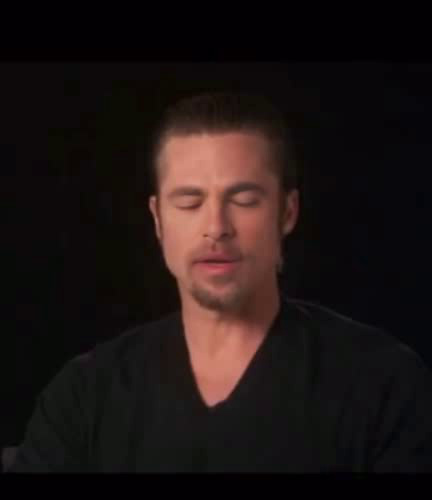

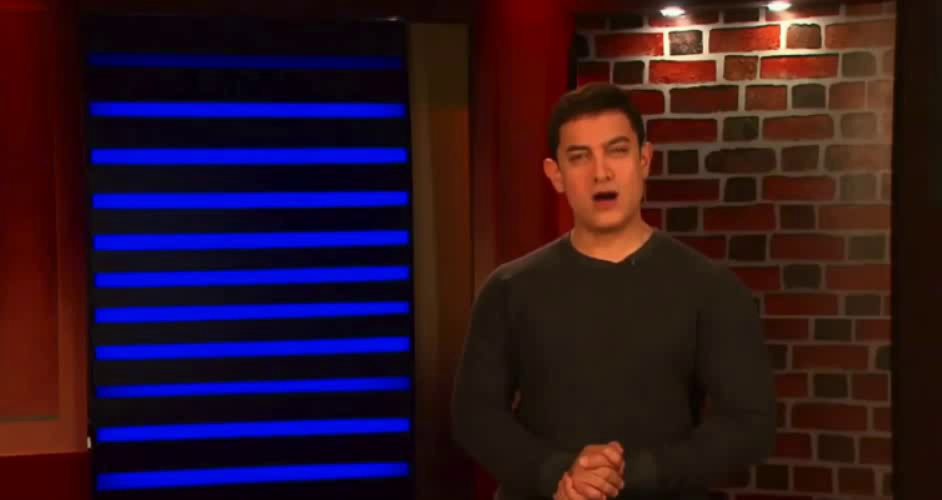

In [18]:
# Looking at the different dimensions of the images

img = Image.open('frame315-1.jpg')
display(img)

img2 = Image.open('frame0-1.jpg')
display(img2)

In [19]:
print(videos_dict['Celeb-real/id0_0000.mp4'][4])

frame0-5.jpg


In [20]:
# Cropping all of the images into a square before scaling them down to 299x299

videos_listX = []
counter = 0

for key,value in videos_dict.items():
  frames = []
  for i in range(0,7,1):
    im = Image.open(videos_dict[key][i])
    width, height = im.size   # Get dimensions

    left = (width - 500)/2
    top = (height - 500)/2
    right = (width + 500)/2
    bottom = (height + 500)/2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    im.thumbnail((299,299))

    data = np.array(im)
    frames.append(data)
    counter += 1
  videos_listX.append(frames)

In [21]:
print(list(range(1,8)))

[1, 2, 3, 4, 5, 6, 7]


In [23]:
print(len(videos_listX[5]))

7


In [24]:
print(videos_listX[20][6])

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [22]:
# New shape of our images - ignore for now

videos_listX[20][6].shape

(299, 299, 3)

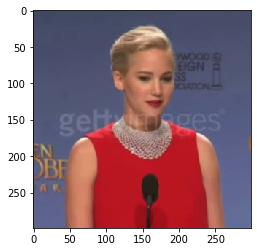

In [23]:
# Displaying new image proportions

plt.imshow(videos_listX[35][2], interpolation='nearest')

### Splitting The Data

Splitting the data into train and test sets.


In [24]:
# Imports needed to split the data
from sklearn.model_selection import train_test_split

In [25]:
# do a train-test split
X_train, X_test, Y_train, Y_test = train_test_split(videos_listX, videos_listY, test_size=0.4, random_state=2)

In [26]:
# splitting valid and train data
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=2)

In [27]:
# converting lists to numpy arrays

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

In [28]:
# confiming successful split 

print(X_train.shape)
print(X_valid.shape)

(386, 7, 299, 299, 3)
(97, 7, 299, 299, 3)


## Training the Data

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model # Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import backend as K
import numpy as np
from sklearn.metrics import confusion_matrix


# CNN
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, ConvLSTM2D

In [30]:
print('# images in X_train: ', len(X_train))
print('# images in X_test: ', len(X_test))
print('# images in X_valid: ', len(X_valid))

# images in X_train:  386
# images in X_test:  323
# images in X_valid:  97


In [31]:
seq_len = 7
img_height = 299
img_width = 299

In [38]:
model = Sequential()
model.add(ConvLSTM2D(filters =8, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(80, activation="relu"))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(7, activation = "sigmoid"))

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 297, 297, 8)       3200      
                                                                 
 dropout_2 (Dropout)         (None, 297, 297, 8)       0         
                                                                 
 flatten_2 (Flatten)         (None, 705672)            0         
                                                                 
 dense_2 (Dense)             (None, 80)                56453840  
                                                                 
 dropout_3 (Dropout)         (None, 80)                0         
                                                                 
 flatten_3 (Flatten)         (None, 80)                0         
                                                                 
 dense_3 (Dense)             (None, 7)                

In [40]:
model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

In [41]:
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True) # early stopping avoids overfitting

In [42]:
# Convert to float after resizing images

X_valid = X_valid.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [ ]:
model.fit(X_train, Y_train, epochs=10000000, callbacks=[es], validation_data=(X_valid,Y_valid))

In [ ]:
## Below is code from our previous model for milestone 2

In [ ]:
## Adding augmented data to our train set
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True,
                                   shear_range=0.2)
img_height = 299
img_width  = 299
X_train_update = X_train[:, :, 0]

train_generator = train_datagen.flow(X_train, Y_train, batch_size=20)


In [ ]:
# Using InceptionV3 model as a basemodel to train our images

base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.evaluate(X_test, Y_test)

In [ ]:
# Percentage of real to fake images in the test set
fake = 0
real = 0
for i in range(len(Y_test)):	
  if Y_test[i] == 0:		
    fake += 1
  elif Y_test[i] == 1:	
    real += 1
    
print("fake: ", fake, "real: ", real)

print("Real: ", 159/(482))
print("Fake: ", 1- (159/(482)))

fake:  323 real:  159
Real:  0.32987551867219916
Fake:  0.6701244813278009


In [ ]:
preds = model.predict(X_test)
preds_label = np.rint(preds)

Our prediction [0.]
Actual result 0
AxesImage(54,36;334.8x217.44)


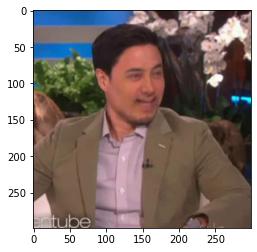

In [ ]:
# Good predicition: This is a fake image and our model predictied it correctly!

print("Our prediction",preds_label[5])
print("Actual result",Y_test[5])
print(plt.imshow(X_test[5]))

Our prediction [1.]
Actual result 0
AxesImage(54,36;334.8x217.44)


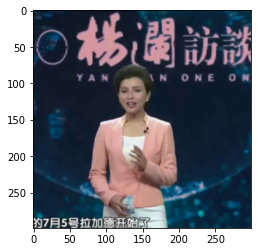

In [ ]:
# Bad Prediction: this image is fake, but we predicted it was real.

print("Our prediction",preds_label[205])
print("Actual result",Y_test[205])
print(plt.imshow(X_test[205]))

In [ ]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(preds_label, Y_test)

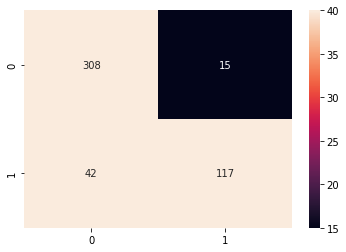

In [ ]:
conf = confusion_matrix(Y_test,preds_label)
sns.heatmap(conf, annot=True, fmt="d", vmax=40)

In [ ]:
tn, fp, fn, tp = confusion_matrix(Y_test, preds_label).ravel()
print("True Negative",tn)
print("True Postive",tp)
print("False Negative",fn)
print("False Positive",fp)

True Negative 308
True Postive 117
False Negative 42
False Positive 15


In [ ]:
# This was our first model attempt - just using CNN. The accuracy was only .67
# on our test set. This model was not doing any better than guessing

# CNN model
old_model = Sequential()
old_model.add(Conv2D(16, 10, input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3],), # (721, 188, 354)
                activation='relu', kernel_initializer='he_normal'))  # output filter size = 6x6, kernel size = 5x5
old_model.add(BatchNormalization())  #improves results
old_model.add(MaxPool2D()) #pooling
old_model.add(Dropout(0.25))
old_model.add(Conv2D(32, 10, activation='relu', kernel_initializer='he_normal'))
old_model.add(BatchNormalization())
old_model.add(Dropout(0.25))

##
old_model.add(Flatten()) # flatten to go into the fully connected model
old_model.add(Dense(60, activation='relu', kernel_initializer='he_normal')) # fully connected model
old_model.add(Dropout(0.25))
old_model.add(Dense(1, activation='sigmoid')) # output

old_model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

old_model.fit(X_train, Y_train, epochs = 10000000000000000, 
          callbacks=[es],
          batch_size=256, shuffle=True,
          validation_split=0.2)


## Predict 